Combine the LRGs from Denali and SV3

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [2]:
from matplotlib.ticker import FormatStrFormatter
sys.path.append(os.path.expanduser('~/git/desi-lrg-selection'))
import plotting_scripts as lrg_plot
import importlib
importlib.reload(lrg_plot)

<module 'plotting_scripts' from '/global/homes/r/rongpu/git/desi-lrg-selection/plotting_scripts.py'>

In [3]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [4]:
# Denali

tmp = Table(fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/denali/testdenali/All/alltiles_Allzinfo.fits', columns=['SV1_DESI_TARGET', 'TARGETS', 'coadd_type']))
mask = (tmp['SV1_DESI_TARGET'] & 2**0 > 0) & (tmp['TARGETS']=='QSO+LRG') & (tmp['coadd_type']=='cumulative')
idx = np.where(mask)[0]
zbest = Table(fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/denali/testdenali/All/alltiles_Allzinfo.fits', rows=idx))
print(len(zbest))
print(len(np.unique(zbest['TARGETID'])))

# Remove FIBERSTATUS!=0 fibers
mask = zbest['FIBERSTATUS']==0
print('FIBERSTATUS',np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
zbest = zbest[mask]

# Remove "no data" fibers
mask = zbest['ZWARN'] & 2**9==0
print('No data', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
zbest = zbest[mask]

# Require a minimum depth for the deep coadd
min_depth = 2000.
mask = zbest['EFFTIME_DARK']>min_depth
print('Min depth', np.sum(mask), np.sum(~mask), np.sum(mask)/len(mask))
zbest = zbest[mask]

zbest.rename_columns(['TARGET_RA', 'TARGET_DEC'], ['RA', 'DEC'])

52268
52023
FIBERSTATUS 43371 8897 0.17021887196755184
No data 43368 3 6.917064397869545e-05
Min depth 36843 6525 0.8495434421693414


In [5]:
# SV3

zbest_path = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/v0/LRGAlltiles_full.dat.fits'
zbest1 = Table(fitsio.read(zbest_path))
print(len(zbest1))
print(len(np.unique(zbest1['TARGETID'])))

# Remove FIBERSTATUS!=0 fibers
mask = zbest1['FIBERSTATUS']==0
print('FIBERSTATUS',np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
zbest1 = zbest1[mask]

# Remove "no data" fibers
mask = zbest1['ZWARN'] & 2**9==0
print('No data', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
zbest1 = zbest1[mask]

# Require a minimum depth for the deep coadd
min_tsnr_lrg = 80.
mask = zbest1['TSNR2_LRG']>min_tsnr_lrg
print('Min depth', np.sum(mask), np.sum(~mask), np.sum(mask)/len(mask))
zbest1 = zbest1[mask]

103823
103823
FIBERSTATUS 98822 5001 0.04816851757317743
No data 98822 0 0.0
Min depth 93944 4878 0.9506385217866467


In [6]:
columns = np.intersect1d(zbest.colnames, zbest1.colnames)
print(columns)
zbest = zbest[list(columns)]
zbest1 = zbest1[list(columns)]

zbest['program'] = 'sv1'
zbest1['program'] = 'sv3'

['BRICKID' 'BRICKNAME' 'BRICK_OBJID' 'CHI2' 'COEFF' 'DEC' 'DELTACHI2'
 'EBV' 'FIBER' 'FIBERFLUX_G' 'FIBERFLUX_R' 'FIBERFLUX_Z' 'FIBERSTATUS'
 'FIBERTOTFLUX_G' 'FIBERTOTFLUX_R' 'FIBERTOTFLUX_Z' 'FLUX_G' 'FLUX_IVAR_G'
 'FLUX_IVAR_R' 'FLUX_IVAR_W1' 'FLUX_IVAR_W2' 'FLUX_IVAR_Z' 'FLUX_R'
 'FLUX_W1' 'FLUX_W2' 'FLUX_Z' 'LOCATION' 'MASKBITS' 'MORPHTYPE' 'NCOEFF'
 'NPIXELS' 'NUMOBS_INIT' 'OBSCONDITIONS' 'PARALLAX' 'PHOTSYS' 'PMDEC'
 'PMRA' 'PRIORITY' 'PRIORITY_INIT' 'PSF_TO_FIBER_SPECFLUX' 'RA'
 'REF_EPOCH' 'RELEASE' 'SPECTYPE' 'SUBPRIORITY' 'SUBTYPE' 'TARGETID'
 'TSNR2_BGS' 'TSNR2_ELG' 'TSNR2_LRG' 'TSNR2_QSO' 'Z' 'ZERR' 'ZWARN']


In [7]:
zbest = vstack([zbest, zbest1])
print(len(zbest), len(np.unique(zbest['TARGETID'])))

130787 129994


In [8]:
# Custom DELTACHI2 vs z cut
d = (10**(3 - 3.5*zbest['Z']))
mask_remove = (d>30) & (zbest['DELTACHI2']<30)
mask_remove |= (d<30) & (zbest['DELTACHI2']<d)
mask_remove |= (zbest['DELTACHI2']<10)
mask_quality = zbest['ZWARN']==0
mask_quality &= zbest['Z']<1.4
mask_quality &= (~mask_remove)
print(np.sum(~mask_quality)/len(mask_quality))

zbest = zbest[mask_quality]
print(len(zbest), len(np.unique(zbest['TARGETID'])))

0.019604394932218033
128223 127448


In [9]:
# # Remove duplicates
# _, idx = np.unique(zbest['TARGETID'], return_index=True)
# zbest = zbest[idx]
# print(len(zbest), len(np.unique(zbest['TARGETID'])))

__Add MEDIUM mask__

In [10]:
maskbits = [8, 9]

mask_clean = np.ones(len(zbest), dtype=bool)
for bit in maskbits:
    mask_clean &= (zbest['MASKBITS'] & 2**bit)==0
print(np.sum(~mask_clean), np.sum(~mask_clean)/len(mask_clean))

# mask_clean &= (zbest['NOBS_G']>=min_nobs) & (zbest['NOBS_R']>=min_nobs) & (zbest['NOBS_Z']>=min_nobs)
# print(np.sum(~mask_clean)/len(mask_clean))

zbest = zbest[mask_clean]
print(len(zbest), len(np.unique(zbest['TARGETID'])))

1285 0.010021602988543397
126938 126164


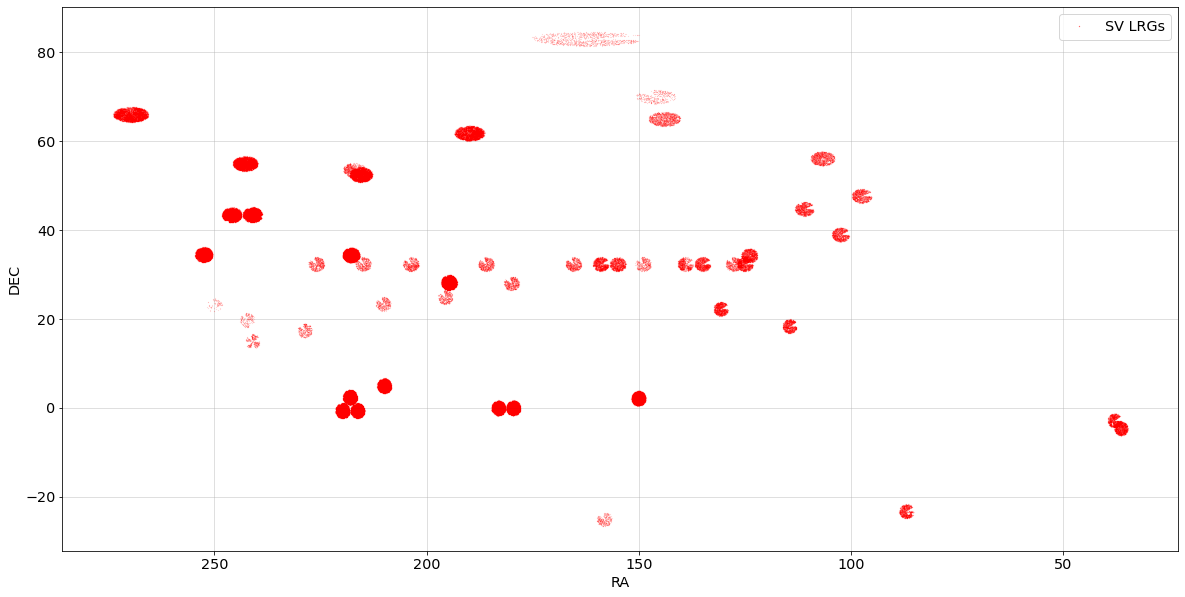

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(zbest['RA'], zbest['DEC'], 'r.', ms=.1, label='SV LRGs')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend(loc='upper right', markerscale=5)
plt.grid(alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    zbest['gmag'] = 22.5 - 2.5*np.log10(zbest['FLUX_G']) - 3.214 * zbest['EBV']
    zbest['rmag'] = 22.5 - 2.5*np.log10(zbest['FLUX_R']) - 2.165 * zbest['EBV']
    zbest['zmag'] = 22.5 - 2.5*np.log10(zbest['FLUX_Z']) - 1.211 * zbest['EBV']
    zbest['w1mag'] = 22.5 - 2.5*np.log10(zbest['FLUX_W1']) - 0.184 * zbest['EBV']
    zbest['w2mag'] = 22.5 - 2.5*np.log10(zbest['FLUX_W2']) - 0.113 * zbest['EBV']
    zbest['gfibermag'] = 22.5 - 2.5*np.log10(zbest['FIBERFLUX_G']) - 3.214 * zbest['EBV']
    zbest['rfibermag'] = 22.5 - 2.5*np.log10(zbest['FIBERFLUX_R']) - 2.165 * zbest['EBV']
    zbest['zfibermag'] = 22.5 - 2.5*np.log10(zbest['FIBERFLUX_Z']) - 1.211 * zbest['EBV']

In [13]:
gmag = zbest['gmag']
rmag = zbest['rmag']
zmag = zbest['zmag']
w1mag = zbest['w1mag']
w2mag = zbest['w2mag']
rfibermag = zbest['rfibermag']
zfibermag = zbest['zfibermag']
# gaia_g = zbest['GAIA_PHOT_G_MEAN_MAG']

mask_north = zbest['PHOTSYS']=='N'
mask_south = zbest['PHOTSYS']=='S'

In [14]:
# mask_north = zbest['PHOTSYS']=='N'
# mask_south = zbest['PHOTSYS']=='S'

# South
lrg_mask = mask_south.copy()
lrg_mask &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.6)                   # faint limit

lrg_mask_sliding = rmag - w1mag > (w1mag - 17.14) * 1.8  # sliding IR cut
lrg_mask_sliding &= rmag - w1mag > (w1mag - 16.33) * 1.  # low-z sliding IR cut
lrg_mask_sliding |= rmag - w1mag > 3.3
lrg_mask &= lrg_mask_sliding

mask_lowz = gmag - w1mag > 2.9  # low-z cut
mask_lowz |= rmag - w1mag > 1.8  # low-z cut
lrg_mask &= mask_lowz

# mask_bright = (gaia_g!=0) & (gaia_g < 18)
# lrg_mask &= (~mask_bright)

# lrg_mask &= (zfibertotmag>17.5)

lrg_new_south = lrg_mask.copy()

# North
lrg_mask = mask_north.copy()
lrg_mask &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.61)                   # faint limit

lrg_mask_sliding = rmag - w1mag > (w1mag - 17.13) * 1.83  # sliding IR cut
lrg_mask_sliding &= rmag - w1mag > (w1mag - 16.31) * 1.   # low-z sliding IR cut
lrg_mask_sliding |= rmag - w1mag > 3.4
lrg_mask &= lrg_mask_sliding

mask_lowz = gmag - w1mag > 2.97  # low-z cut
mask_lowz |= rmag - w1mag > 1.8  # low-z cut
lrg_mask &= mask_lowz

# mask_bright = (gaia_g!=0) & (gaia_g < 18)
# lrg_mask &= (~mask_bright)

# lrg_mask &= (zfibertotmag>17.5)

lrg_new_north = lrg_mask.copy()

lrg_new = lrg_new_south | lrg_new_north
print(np.sum(lrg_new))

79453


In [15]:
print(np.unique(zbest['program'][lrg_new], return_counts=True))

(<Column name='program' dtype='str3' length=2>
sv1
sv3, array([ 9790, 69663]))


In [16]:
mask = zbest['program']=='sv3'
weights = np.ones(len(zbest))
weights[mask] = 1/10

In [17]:
# numbers from another notebook
area_tot = 10109.0
n_lrg_new_tot = 6159414
density_tot = n_lrg_new_tot/area_tot
print(density_tot)

area_south = np.sum(weights[lrg_new_south])/n_lrg_new_tot * area_tot
print(area_south)

area_north = np.sum(weights[lrg_new_north])/n_lrg_new_tot * area_tot
print(area_north)

area = area_south + area_north
print(area)

609.3000296765259
14.4145733993526
13.086327936391351
27.50090133574395


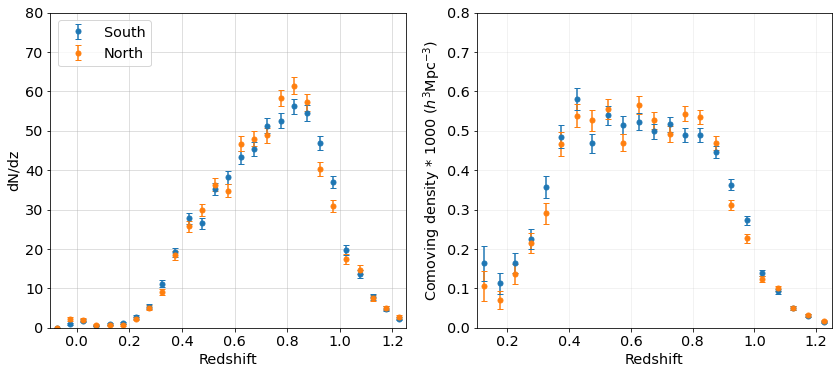

In [18]:
# North and south separately

bins = np.arange(-0.1, 1.45, 0.05)
bin_centers = (bins[1:]+bins[:-1])/2

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    counts_south, _ = np.histogram(zbest['Z'][lrg_new_south], bins=bins, weights=weights[lrg_new_south])
    frac_err_south = 1/np.sqrt(counts_south)  # Poisson error only
    counts_north, _ = np.histogram(zbest['Z'][lrg_new_north], bins=bins, weights=weights[lrg_new_north])
    frac_err_north = 1/np.sqrt(counts_north)  # Poisson error only
    frac_err_south[~np.isfinite(frac_err_south)] = 0
    frac_err_north[~np.isfinite(frac_err_north)] = 0
    
fig, axes = plt.subplots(1, 2, figsize=(14, 5.8))
axes[0].errorbar(bin_centers, counts_south/area_south, yerr=frac_err_south*counts_south/area_south, fmt='o', ms=5, color='C0', capsize=3, capthick=1, label='South')
axes[0].errorbar(bin_centers, counts_north/area_north, yerr=frac_err_north*counts_north/area_north, fmt='o', ms=5, color='C1', capsize=3, capthick=1, label='North')
axes[0].legend(loc='upper left')
axes[0].set_xlabel('Redshift')
axes[0].set_ylabel('dN/dz')
axes[0].set_xlim(-0.1, 1.25)
axes[0].set_ylim(0, 80)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[0].grid(alpha=0.5)
# axes[0].set_ylim(top=30)
axes[1] = lrg_plot.plot_comoving_density(zbest['Z'][lrg_new_south], area=area_south, zmin=0.1, zmax=1.45, dz=0.05, axis=[0.1, 1.25, 0, 0.8], xlabel='Redshift', show=False, lw=1.5, color='C0', errorbar=True, weights=weights[lrg_new_south])
axes[1] = lrg_plot.plot_comoving_density(zbest['Z'][lrg_new_north], area=area_north, zmin=0.1, zmax=1.45, dz=0.05, axis=[0.1, 1.25, 0, 0.8], xlabel='Redshift', show=False, lw=1.5, color='C1', errorbar=True, weights=weights[lrg_new_north])
# plt.legend(loc='lower left')
plt.show()

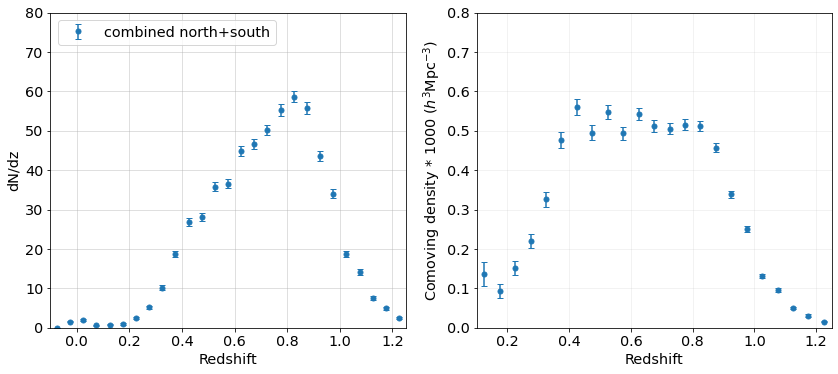

In [19]:
# North and south combined

bins = np.arange(-0.1, 1.45, 0.05)
bin_centers = (bins[1:]+bins[:-1])/2

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    counts, _ = np.histogram(zbest['Z'][lrg_new], bins=bins, weights=weights[lrg_new])
    frac_err = 1/np.sqrt(counts)  # Poisson error only
    frac_err[~np.isfinite(frac_err)] = 0
    
fig, axes = plt.subplots(1, 2, figsize=(14, 5.8))
axes[0].errorbar(bin_centers, counts/area, yerr=frac_err*counts/area, fmt='o', ms=5, color='C0', capsize=3, capthick=1, label='combined north+south')
axes[0].legend(loc='upper left')
axes[0].set_xlabel('Redshift')
axes[0].set_ylabel('dN/dz')
axes[0].set_xlim(-0.1, 1.25)
axes[0].set_ylim(0, 80)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axes[0].grid(alpha=0.5)
# axes[0].set_ylim(top=30)
axes[1] = lrg_plot.plot_comoving_density(zbest['Z'][lrg_new], area=area, zmin=0.1, zmax=1.45, dz=0.05, axis=[0.1, 1.25, 0, 0.8], xlabel='Redshift', show=False, lw=1.5, color='C0', errorbar=True, weights=weights[lrg_new])
# plt.legend(loc='lower left')
plt.show()

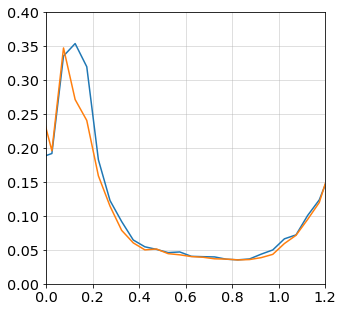

In [20]:
# Fractional uncertainty
plt.figure(figsize=(5, 5))
plt.plot(bin_centers, frac_err_north)
plt.plot(bin_centers, frac_err_south)
plt.axis([0, 1.2, 0, 0.4])
plt.grid(alpha=0.5)

In [21]:
mask_star = (zbest['SPECTYPE']=='STAR') | (zbest['Z']<0.0003)
print('Stars: {:.1f} ({:.2f}%)'.format(np.sum(mask_star & lrg_new)/np.sum(lrg_new)*density_tot, np.sum(mask_star & lrg_new)/np.sum(lrg_new)*100))

bins = np.round(np.arange(0., 1.5, 0.1), 2)

# surface density
counts = np.histogram(zbest['Z'][lrg_new & (~mask_star)], bins=bins, weights=weights[lrg_new & (~mask_star)])[0]
surf_density = counts/area

t = Table()
t['zmin'] = bins[:-1]
t['zmax'] = bins[1:]
t['N_z_norm'] = surf_density/density_tot
t['N_z_norm'].format = '%.4f'
t['N_z'] = surf_density
t['N_z'].format = '%.1f'
# t['comoving_density'] = comov_density
# t.write('data/lrg_dndz_20210330.txt', format='ascii.commented_header', 
#        formats={'zmin':'%4.2f', 'zmax':'%4.2f', 'N_z_800':'%.10g', 'N_z_600':'%.10g'},
#        overwrite=True)
print(np.sum(t['N_z']))
t

Stars: 1.7 (0.28%)
605.8383249555144


zmin,zmax,N_z_norm,N_z
float64,float64,float64,float64
0.0,0.1,0.0011,0.7
0.1,0.2,0.0029,1.8
0.2,0.3,0.0127,7.7
0.3,0.4,0.0476,29.0
0.4,0.5,0.0901,54.9
0.5,0.6,0.1186,72.3
0.6,0.7,0.1503,91.6
0.7,0.8,0.1730,105.4
0.8,0.9,0.1879,114.5


In [22]:
# Normalize to the total density in lrg_redshift_distributions-sv1_deep.ipynb
t1 = t.copy()
t1['N_z'] = t1['N_z'] * (598.3/np.sum(t1['N_z']))
print(np.sum(t1['N_z']))
t1

598.3000000000001


zmin,zmax,N_z_norm,N_z
float64,float64,float64,float64
0.0,0.1,0.0011,0.7
0.1,0.2,0.0029,1.7
0.2,0.3,0.0127,7.6
0.3,0.4,0.0476,28.6
0.4,0.5,0.0901,54.2
0.5,0.6,0.1186,71.4
0.6,0.7,0.1503,90.4
0.7,0.8,0.1730,104.1
0.8,0.9,0.1879,113.1


--------
# N(z) of nominal exposures

In [23]:
comp = Table.read('completeness_vs_redshift.txt', format='ascii.commented_header')

In [24]:
comp['incomp_frac'] = 1 - comp['comp_frac']
comp = comp[['zmin', 'zmax', 'N_all', 'N_secure', 'incomp_frac']]
comp['incomp_frac'].format = '%.4f'

In [25]:
comp

zmin,zmax,N_all,N_secure,incomp_frac
float64,float64,int64,int64,float64
0.3,0.4,698,695,0.0043
0.4,0.5,1310,1293,0.0130
0.5,0.6,1675,1633,0.0251
0.6,0.7,2024,1968,0.0277
0.7,0.8,2552,2444,0.0423
0.8,0.9,2555,2448,0.0419
0.9,1.0,1953,1817,0.0696
1.0,1.1,813,790,0.0283
1.1,1.2,334,320,0.0419


In [26]:
incomp_frac_fiducial = 1-np.sum(comp['N_secure'])/np.sum(comp['N_all'])
incomp_frac_fiducial

0.03642857142857148

__efftime = 900s__

In [29]:
incomp_frac = 1-(609.2-23-5)/np.sum(t1['N_z'])
incomp_frac

0.02858097944175164

In [30]:
comp['incomp_frac_norm'] = comp['incomp_frac'] * incomp_frac / incomp_frac_fiducial

In [31]:
comp

zmin,zmax,N_all,N_secure,incomp_frac,incomp_frac_norm
float64,float64,int64,int64,float64,float64
0.3,0.4,698,695,0.0043,0.0034
0.4,0.5,1310,1293,0.0130,0.0102
0.5,0.6,1675,1633,0.0251,0.0197
0.6,0.7,2024,1968,0.0277,0.0217
0.7,0.8,2552,2444,0.0423,0.0332
0.8,0.9,2555,2448,0.0419,0.0329
0.9,1.0,1953,1817,0.0696,0.0546
1.0,1.1,813,790,0.0283,0.0222
1.1,1.2,334,320,0.0419,0.0329


In [32]:
t2 = t1.copy()
t2 = join(t2, comp[['zmin', 'incomp_frac_norm']], keys='zmin', join_type='outer').filled(0)

In [33]:
t2

zmin,zmax,N_z_norm,N_z,incomp_frac_norm
float64,float64,float64,float64,float64
0.0,0.1,0.0011,0.7,0.0000
0.1,0.2,0.0029,1.7,0.0000
0.2,0.3,0.0127,7.6,0.0000
0.3,0.4,0.0476,28.6,0.0034
0.4,0.5,0.0901,54.2,0.0102
0.5,0.6,0.1186,71.4,0.0197
0.6,0.7,0.1503,90.4,0.0217
0.7,0.8,0.1730,104.1,0.0332
0.8,0.9,0.1879,113.1,0.0329


In [34]:
t2['N_z_reliable'] = t2['N_z'] * (1-t2['incomp_frac_norm'])

In [35]:
t2

zmin,zmax,N_z_norm,N_z,incomp_frac_norm,N_z_reliable
float64,float64,float64,float64,float64,float64
0.0,0.1,0.0011,0.7,0.0000,0.7
0.1,0.2,0.0029,1.7,0.0000,1.7
0.2,0.3,0.0127,7.6,0.0000,7.6
0.3,0.4,0.0476,28.6,0.0034,28.5
0.4,0.5,0.0901,54.2,0.0102,53.7
0.5,0.6,0.1186,71.4,0.0197,70.0
0.6,0.7,0.1503,90.4,0.0217,88.5
0.7,0.8,0.1730,104.1,0.0332,100.6
0.8,0.9,0.1879,113.1,0.0329,109.3


In [36]:
np.sum(t2['N_z_reliable'])

581.6532504579649

__efftime = 1100s__

In [37]:
incomp_frac = 1-(609.2-14-5)/np.sum(t1['N_z'])
incomp_frac

0.01353835868293507

In [38]:
comp['incomp_frac_norm'] = comp['incomp_frac'] * incomp_frac / incomp_frac_fiducial

In [39]:
comp

zmin,zmax,N_all,N_secure,incomp_frac,incomp_frac_norm
float64,float64,int64,int64,float64,float64
0.3,0.4,698,695,0.0043,0.0016
0.4,0.5,1310,1293,0.0130,0.0048
0.5,0.6,1675,1633,0.0251,0.0093
0.6,0.7,2024,1968,0.0277,0.0103
0.7,0.8,2552,2444,0.0423,0.0157
0.8,0.9,2555,2448,0.0419,0.0156
0.9,1.0,1953,1817,0.0696,0.0259
1.0,1.1,813,790,0.0283,0.0105
1.1,1.2,334,320,0.0419,0.0156


In [40]:
t2 = t1.copy()
t2 = join(t2, comp[['zmin', 'incomp_frac_norm']], keys='zmin', join_type='outer').filled(0)

In [41]:
t2

zmin,zmax,N_z_norm,N_z,incomp_frac_norm
float64,float64,float64,float64,float64
0.0,0.1,0.0011,0.7,0.0000
0.1,0.2,0.0029,1.7,0.0000
0.2,0.3,0.0127,7.6,0.0000
0.3,0.4,0.0476,28.6,0.0016
0.4,0.5,0.0901,54.2,0.0048
0.5,0.6,0.1186,71.4,0.0093
0.6,0.7,0.1503,90.4,0.0103
0.7,0.8,0.1730,104.1,0.0157
0.8,0.9,0.1879,113.1,0.0156


In [42]:
t2['N_z_reliable'] = t2['N_z'] * (1-t2['incomp_frac_norm'])

In [43]:
t2

zmin,zmax,N_z_norm,N_z,incomp_frac_norm,N_z_reliable
float64,float64,float64,float64,float64,float64
0.0,0.1,0.0011,0.7,0.0000,0.7
0.1,0.2,0.0029,1.7,0.0000,1.7
0.2,0.3,0.0127,7.6,0.0000,7.6
0.3,0.4,0.0476,28.6,0.0016,28.6
0.4,0.5,0.0901,54.2,0.0048,54.0
0.5,0.6,0.1186,71.4,0.0093,70.7
0.6,0.7,0.1503,90.4,0.0103,89.5
0.7,0.8,0.1730,104.1,0.0157,102.5
0.8,0.9,0.1879,113.1,0.0156,111.3


In [44]:
np.sum(t2['N_z_reliable'])

590.4146975853517